<a href="https://colab.research.google.com/github/17260453/doprax1/blob/main/step-by-step-llm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tiktoken

In [ ]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
import tiktoken
import torch
import torch.nn as nn

In [ ]:
# Hyperparameters
batch_size = 4  # How many batches per training step
context_length = 16  # Length of the token chunk each batch
d_model = 64  # The vector size of the token embeddings
num_layers = 8  # Number of transformer blocks
num_heads = 4  # Number of heads in Multi-head attention # 我们的代码中通过 d_model / num_heads = 来获取 head_size
learning_rate = 1e-3  # 0.001
dropout = 0.1 # Dropout rate
max_iters = 500  # Total of training iterations
eval_interval = 50  # How often to evaluate the model
eval_iters = 20  # How many iterations to average the loss over when evaluating the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Instead of using the cpu, we'll use the GPU if it's available.

TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

In [ ]:
# download a sample txt file from https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt
if not os.path.exists('sales_textbook.txt'):
    url = 'https://huggingface.co/datasets/goendalf666/sales-textbook_for_convincing_and_selling/raw/main/sales_textbook.txt'
    with open('sales_textbook.txt', 'w') as f:
        f.write(requests.get(url).text)

with open('sales_textbook.txt', 'r', encoding='utf-8') as f:
    text = f.read()


In [ ]:
# Using TikToken to tokenize the source text
encoding = tiktoken.get_encoding("cl100k_base")
tokenized_text = encoding.encode(text)
tokenized_text = torch.tensor(tokenized_text, dtype=torch.long, device=device) # Convert tokens into a tensor
max_token_value = tokenized_text.max().item() # the maximum index value in our vocabulary

print(f"Tokenized text size: {len(tokenized_text)}")
print(f"The maximum value in the tokenized text is: {max_token_value}")

Tokenized text size: 77919
The maximum value in the tokenized text is: 100069


In [ ]:
# Illustration purpose
print(encoding.encode('Chapter 1: Building Rapport and Capturing'))
print(encoding.decode([26072, 220, 16, 25, 17283, 23097, 403, 323, 17013, 1711])) # "Rapport" is tokenized as two tokens: "Rap"[23097] and "port"[403]
print(encoding.decode([627, 1383, 88861, 279,1989, 315, 25607, 16940, 65931, 323, 32097, 11, 584, 26458, 13520, 449]))

[26072, 220, 16, 25, 17283, 23097, 403, 323, 17013, 1711]
Chapter 1: Building Rapport and Capturing
.
By mastering the art of identifying underlying motivations and desires, we equip ourselves with


In [ ]:
# Split train and validation
split_idx = int(len(tokenized_text) * 0.9)
train_data = tokenized_text[:split_idx]
val_data = tokenized_text[split_idx:]

In [ ]:
# Prepare data for training batch
data = train_data
idxs = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,))
x_batch = torch.stack([data[idx:idx + context_length] for idx in idxs])
y_batch = torch.stack([data[idx + 1:idx + context_length + 1] for idx in idxs])
print(x_batch.shape, x_batch.shape)

torch.Size([4, 16]) torch.Size([4, 16])


In [ ]:
# Illustration purpose
pd.set_option('display.expand_frame_repr', False)
print("Our batches:\n", pd.DataFrame(x_batch.data.detach().cpu().numpy()))

Our batches:
       0      1     2      3     4      5      6      7      8      9    10     11     12     13     14     15
0    279   6763  1920     13   578   5845    311  13750  19570    279  907    323   7720    315   1057   3956
1   3495  14955    11    477  5064  23146    430   9788    279  66732  315    701  10209     13   3296  32644
2  38769  10742    11  20958   264   6928  19451     11  11125  64784   11    323  56501  54111    439   6975
3  43496    872  8830    719  1101   3727    279   6130   2733   6755  323  16365    627  29831  19682   5900


In [ ]:
# Define Token Embedding look-up table
token_embedding_lookup_table = nn.Embedding(max_token_value+1, d_model, device=device)
print("Token Embedding Look-up table: ", token_embedding_lookup_table)

Token Embedding Look-up table:  Embedding(100070, 64)


In [ ]:
# Get x and y embedding
x_batch_embedding = token_embedding_lookup_table(x_batch.data) # [4, 16, 64] [batch_size, context_length, d_model]
y_batch_embedding = token_embedding_lookup_table(y_batch.data)

x_batch_embedding.shape, y_batch_embedding.shape

(torch.Size([4, 16, 64]), torch.Size([4, 16, 64]))

In [ ]:
# Define Position Encoding look-up table
position_encoding_lookup_table = torch.zeros(context_length, d_model, device=device)
position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
position_encoding_lookup_table[:, 0::2] = torch.sin(position * div_term)
position_encoding_lookup_table[:, 1::2] = torch.cos(position * div_term)
position_encoding_lookup_table = position_encoding_lookup_table.unsqueeze(0).expand(batch_size, -1, -1) #add batch dimension

print("Position Encoding Look-up Table: ", position_encoding_lookup_table.shape) # [4, 16, 64] [batch_size, context_length, d_model]
pd.DataFrame(position_encoding_lookup_table[0].detach().cpu().numpy())

Position Encoding Look-up Table:  torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.841471,0.540302,0.681561,0.731761,0.533168,0.846009,0.409309,0.912396,0.310984,0.950415,...,0.000422,1.000000,0.000316,1.000000,0.000237,1.000000,0.000178,1.000000,0.000133,1.000000
2,0.909297,-0.416147,0.997480,0.070948,0.902131,0.431463,0.746903,0.664932,0.591127,0.806578,...,0.000843,1.000000,0.000632,1.000000,0.000474,1.000000,0.000356,1.000000,0.000267,1.000000
3,0.141120,-0.989992,0.778273,-0.627927,0.993253,-0.115966,0.953634,0.300967,0.812649,0.582754,...,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000,0.000400,1.000000
4,-0.756802,-0.653644,0.141539,-0.989933,0.778472,-0.627680,0.993281,-0.115730,0.953581,0.301137,...,0.001687,0.999999,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000
5,-0.958924,0.283662,-0.571127,-0.820862,0.323935,-0.946079,0.858896,-0.512150,0.999947,-0.010342,...,0.002108,0.999998,0.001581,0.999999,0.001186,0.999999,0.000889,1.000000,0.000667,1.000000
6,-0.279415,0.960170,-0.977396,-0.211416,-0.230368,-0.973104,0.574026,-0.818837,0.947148,-0.320796,...,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999,0.000800,1.000000
7,0.656987,0.753902,-0.859313,0.511449,-0.713721,-0.700430,0.188581,-0.982058,0.800422,-0.599437,...,0.002952,0.999996,0.002214,0.999998,0.001660,0.999999,0.001245,0.999999,0.000933,1.000000
8,0.989358,-0.145500,-0.280228,0.959933,-0.977262,-0.212036,-0.229904,-0.973213,0.574318,-0.818632,...,0.003374,0.999994,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999
9,0.412118,-0.911130,0.449194,0.893434,-0.939824,0.341660,-0.608108,-0.793854,0.291259,-0.956644,...,0.003795,0.999993,0.002846,0.999996,0.002134,0.999998,0.001600,0.999999,0.001200,0.999999


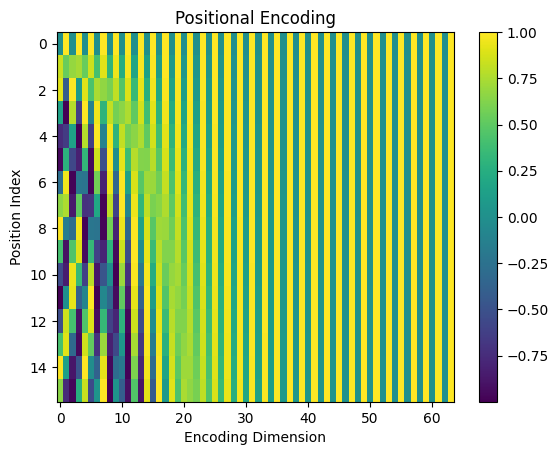

In [ ]:
# Illustration Purpose Only
def visualize_pe(pe):
    plt.imshow(pe, aspect="auto")
    plt.title("Positional Encoding")
    plt.xlabel("Encoding Dimension")
    plt.ylabel("Position Index")
    plt.colorbar()
    plt.show()

position_encoding_lookup_table2_np = position_encoding_lookup_table[0].cpu().numpy()
visualize_pe(position_encoding_lookup_table2_np)

In [ ]:
# Add positional encoding into the input embedding vector
input_embedding_x = x_batch_embedding + position_encoding_lookup_table # [4, 16, 64] [batch_size, context_length, d_model]
input_embedding_y = y_batch_embedding + position_encoding_lookup_table
pd.DataFrame(input_embedding_x[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-1.381821,1.126630,-0.068038,1.004914,0.397089,0.390446,0.165830,1.264523,0.511881,-0.436891,...,0.033304,3.330629,1.710708,0.761049,0.284749,2.828507,-2.765064,0.416959,-1.255374,2.393023
1,3.008820,0.307113,-0.335300,1.245556,0.907487,1.299178,0.344684,0.321622,-0.104312,2.205549,...,0.464557,2.277286,-0.516410,1.109403,-0.022677,0.078038,-0.722685,0.839766,2.459578,0.818341
2,1.263144,-0.200434,-0.456763,1.011367,1.206234,1.155965,1.602273,0.728407,0.043684,1.839955,...,0.714719,3.503687,0.463423,0.400269,-0.805720,2.225636,0.861546,1.713152,0.745801,0.494103
3,0.515495,-1.986732,1.178686,-1.574358,2.991423,0.649950,-0.170691,0.450255,0.576874,-0.520026,...,0.190935,0.024446,0.401720,3.611576,0.456005,1.168910,-0.923507,1.832411,0.089966,1.518397
4,-1.134752,-1.094044,0.245667,-0.541750,-1.754543,-0.543972,1.662775,0.811621,0.993274,0.217259,...,0.568342,-0.096469,-0.231047,-0.421297,0.427320,-0.036839,-0.512698,-1.382263,0.362276,0.712890
5,-1.211708,2.233657,-2.042748,-1.028316,-1.216628,-2.032929,0.134213,0.680358,3.181762,0.348922,...,1.411706,0.498144,-0.802397,0.692983,-0.924256,0.512848,-0.450975,0.933045,1.356728,1.103436
6,-0.384030,0.118699,-3.382173,0.610193,-0.168701,-1.338553,0.506079,-0.465532,1.281263,0.949558,...,0.890298,1.247213,1.494171,-0.115025,0.182102,-1.277406,0.245401,2.697041,0.582494,1.727776
7,0.353745,0.865835,-1.443851,-0.016276,-0.108631,0.119624,-0.401600,-0.873925,-1.055093,-1.176494,...,-2.053286,1.784168,-0.558767,1.650910,1.961911,-0.153587,0.149539,0.258725,2.585723,-0.642184
8,1.457316,1.616811,0.400090,0.179979,-1.993636,0.486149,-0.564167,-1.806118,-2.143988,-3.097260,...,-0.198422,1.834837,-0.438702,0.608716,0.874097,1.175616,1.663757,2.327910,0.316881,0.989522
9,-0.969702,-0.784501,0.381156,0.898348,-0.542735,-0.267893,-0.442278,-0.529331,0.803140,-2.393535,...,0.037099,3.330622,1.713554,0.761045,0.286883,2.828505,-2.763464,0.416958,-1.254174,2.393022


In [ ]:
# Prepare Query, Key, Value for Multi-head Attention
X = input_embedding_x
query = key = value = X # [4, 16, 64] [batch_size, context_length, d_model]
query.shape
X.to(device)

tensor([[[-1.3818e+00,  1.1266e+00, -6.8038e-02,  ...,  4.1696e-01,
          -1.2554e+00,  2.3930e+00],
         [ 3.0088e+00,  3.0711e-01, -3.3530e-01,  ...,  8.3977e-01,
           2.4596e+00,  8.1834e-01],
         [ 1.2631e+00, -2.0043e-01, -4.5676e-01,  ...,  1.7132e+00,
           7.4580e-01,  4.9410e-01],
         ...,
         [ 2.0015e+00, -2.5619e+00, -1.3966e+00,  ..., -4.2588e-04,
          -1.6728e+00,  7.6212e-01],
         [ 2.6567e+00,  6.8404e-01,  8.3430e-01,  ...,  2.7972e+00,
           1.6298e+00,  2.7612e+00],
         [ 7.2102e-01,  9.6613e-01, -1.8745e+00,  ...,  9.9469e-02,
           1.6078e-01,  2.0050e+00]],

        [[ 6.4881e-01,  1.0216e+00,  1.2753e-01,  ...,  8.8638e-01,
          -7.6511e-01,  1.8528e+00],
         [ 9.3236e-01,  1.5345e+00,  4.5743e-01,  ...,  2.0496e+00,
          -6.2755e-01,  8.1492e-01],
         [ 1.3070e+00, -5.6076e-01, -1.0864e+00,  ...,  1.1691e+00,
           5.4912e-02,  3.7899e-01],
         ...,
         [ 7.9454e-01, -8

In [ ]:
# Define Query, Key, Value weight matrices
Wq = nn.Linear(d_model, d_model, device=device)
Wk = nn.Linear(d_model, d_model, device=device)
Wv = nn.Linear(d_model, d_model, device=device)

Q = Wq(query) #[4, 16, 64]
Q = Q.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

K = Wk(key) #[4, 16, 64]
K = K.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

V = Wv(value) #[4, 16, 64]
V = V.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

# print(torch.round(Q[0] * 100) / 100)
qqq = Q.detach().cpu().numpy()
for qs in qqq:
    for qss in qs:
        print(pd.DataFrame(qss))

print(Q.shape) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]

         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0 -0.206788 -0.077137 -0.442887  0.608647  0.491521 -0.347687 -0.441250  0.562284  0.029011 -1.094290 -0.754278 -0.197753  0.763999 -0.807665  0.345962  0.567870
1  0.217925  0.699497 -0.281540 -0.461096 -0.433398  1.303390  1.255399 -0.131456 -0.269423 -0.636081 -0.631267  0.582950  0.218154  1.982726 -0.409440 -0.474220
2  1.620056 -0.231711  0.726748 -0.901504  0.090729  0.136371  0.106373  0.585623 -0.137751 -0.437597 -0.679329  0.169727 -0.493531 -1.675880 -0.727030 -0.294713
3  0.263875  0.017202  0.110883  0.280732  0.152571  0.907317 -1.051489  0.227751 -0.158519 -1.149010 -0.680281 -1.124736 -0.736193  0.573290 -0.114200  0.207662
         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0 -0.084308  0.165369 -0.666

In [ ]:
# Transpose q,k,v from [batch_size, context_length, num_heads, head_size] to [batch_size, num_heads, context_length, head_size]
# The reason is that treat each batch with "num_heads" as its first dimension.
Q = Q.transpose(1, 2) # [4, 4, 16, 16]
K = K.transpose(1, 2) # [4, 4, 16, 16]
V = V.transpose(1, 2) # [4, 4, 16, 16]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.371902,0.218301,-0.103957,0.078929,0.316944,0.471823,-0.221514,0.710314,0.298851,0.086779,0.503181,-0.164992,0.246679,0.050538,0.108994,-0.017793
1,-0.113983,-0.003257,0.063156,0.086828,0.400667,0.178088,-0.359695,0.347564,0.217223,-0.333745,0.595843,-0.369617,0.086265,-0.333779,0.110141,-0.607758
2,0.499353,-0.115571,0.176467,-0.088143,0.003974,0.438337,-0.012787,0.439290,-0.090779,0.224599,0.329817,-0.012971,0.354957,0.002198,0.088236,-0.016219
3,0.120323,0.519504,0.248800,0.531461,0.349053,0.580933,0.180867,0.965858,1.094833,0.038939,0.450644,0.194551,0.372559,0.078271,0.817297,-0.422157
4,0.139874,0.172270,0.223618,-0.190137,0.245468,0.164907,-0.154179,0.065960,-0.294930,-0.143672,-0.050048,-0.016997,-0.138742,-0.357765,0.000532,-0.589060
5,-0.539470,-0.400251,0.471257,0.124875,0.007693,-0.764337,-0.162710,-0.643299,-0.601864,-0.713457,-0.078259,-0.723028,-0.327511,-0.762261,0.336600,-0.915730
6,0.379276,-0.147719,0.055052,-0.404740,0.038846,0.171394,-0.140104,0.137365,-0.464502,0.062999,0.108371,-0.404285,0.241457,0.183911,-0.121141,-0.141739
7,0.392290,0.013818,0.277825,-0.307761,0.150467,0.241570,-0.290271,-0.632151,-0.724389,0.024958,0.015651,-0.474019,-0.136182,-0.869600,-0.121533,-0.437013
8,0.438067,0.924022,0.146566,-0.659651,0.651120,0.528084,-0.018266,0.679950,1.012321,0.091204,-0.025403,0.335978,0.277612,-0.000366,0.742243,0.515101
9,0.649282,0.376737,-0.371088,-0.303000,0.383845,0.596647,-0.257948,1.005650,0.404824,0.328802,0.447787,-0.195183,0.162064,0.232715,0.087193,0.311706


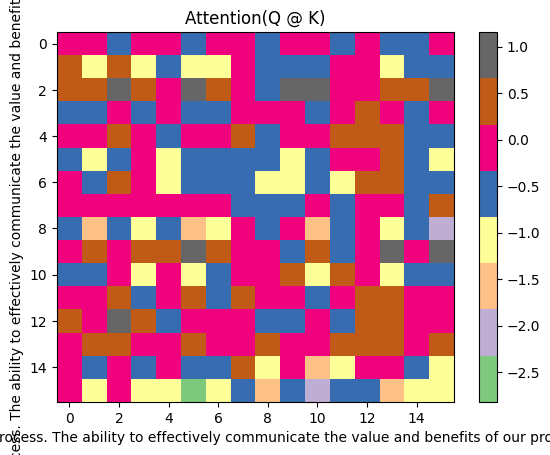

In [ ]:
# Calculate the attention score
attention_score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_model // num_heads) # [4, 4, 16, 16]
attention_score.to(device)
# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q @ K)") #plot attention in the first head of the first batch
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.371902,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1,-0.113983,-0.003257,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,0.499353,-0.115571,0.176467,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
3,0.120323,0.519504,0.248800,0.531461,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
4,0.139874,0.172270,0.223618,-0.190137,0.245468,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
5,-0.539470,-0.400251,0.471257,0.124875,0.007693,-0.764337,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
6,0.379276,-0.147719,0.055052,-0.404740,0.038846,0.171394,-0.140104,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
7,0.392290,0.013818,0.277825,-0.307761,0.150467,0.241570,-0.290271,-0.632151,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
8,0.438067,0.924022,0.146566,-0.659651,0.651120,0.528084,-0.018266,0.679950,1.012321,-inf,-inf,-inf,-inf,-inf,-inf,-inf
9,0.649282,0.376737,-0.371088,-0.303000,0.383845,0.596647,-0.257948,1.005650,0.404824,0.328802,-inf,-inf,-inf,-inf,-inf,-inf


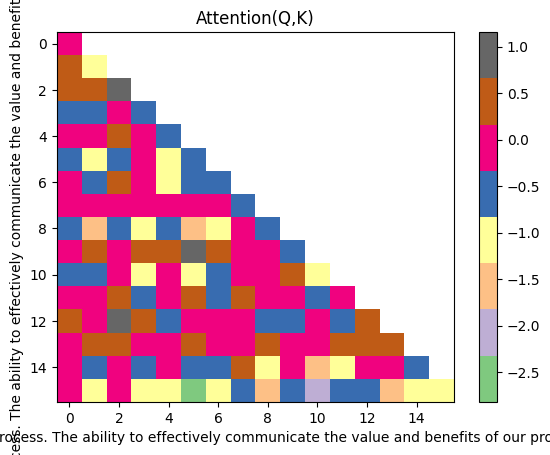

In [ ]:
# Apply Mask to attention scores
attention_score.to("cpu")
attention_score = attention_score.masked_fill(torch.triu(torch.ones(attention_score.shape[-2:]).to(device), diagonal=1).bool(), float('-inf'))#[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q,K)")
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

In [ ]:
# Softmax the attention score
attention_score = torch.softmax(attention_score, dim=-1) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.472347,0.527653,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.441552,0.238739,0.319708,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.194695,0.290213,0.221387,0.293704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.201997,0.208648,0.219642,0.145219,0.224494,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.106756,0.122703,0.293323,0.207450,0.184511,0.085258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.204554,0.120764,0.147911,0.093393,0.145533,0.166160,0.121687,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.179118,0.122679,0.159745,0.088943,0.140643,0.154057,0.090512,0.064303,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.102868,0.167235,0.076857,0.034320,0.127294,0.112557,0.065177,0.131017,0.182674,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.132204,0.100665,0.047655,0.051012,0.101383,0.125426,0.053363,0.188805,0.103533,0.095954,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# Calculate the V attention output
print(attention_score.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
print(V.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
A = torch.matmul(attention_score, V) # [4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
print(A.shape)

torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])


In [ ]:
# Concatenate the attention output
A = A.transpose(1, 2) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]
A = A.reshape(batch_size, -1, d_model) # [4, 16, 64] [batch_size, context_length, d_model]
A.shape

torch.Size([4, 16, 64])

In [ ]:
# Define the output weight matrix
Wo = nn.Linear(d_model, d_model, device=device)
output = Wo(A) # [4, 16, 64] [batch_size, context_length, d_model]
print(output.shape)
pd.DataFrame(output[0].detach().cpu().numpy())

torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.392678,-0.174787,-0.787092,-0.355116,-0.168477,-0.250853,0.018965,0.318376,0.385562,-0.195513,...,-0.234128,0.489544,-0.137074,0.021961,-0.045521,0.304030,0.447654,-0.012007,0.760476,0.522974
1,0.061520,-0.322076,-0.227984,-0.333211,-0.530468,-0.034147,-0.182715,0.628473,0.235821,-0.129199,...,0.101291,0.494961,0.076101,0.037319,-0.173451,0.257269,0.200986,0.117126,0.198669,-0.202365
2,-0.147808,-0.084340,-0.178217,-0.300301,-0.228166,-0.018882,0.017658,0.339426,-0.107094,-0.202726,...,0.172134,0.428534,-0.163117,-0.127476,-0.097744,0.147164,0.095007,0.251559,0.272281,-0.000070
3,-0.030585,-0.217175,-0.214513,-0.413043,-0.120371,-0.035232,0.058642,0.381012,-0.194439,-0.149911,...,0.147709,0.282743,-0.031513,-0.195596,-0.107834,0.217759,0.184756,0.322392,0.272910,0.190733
4,-0.091338,-0.228566,-0.015883,-0.363395,-0.067106,0.079897,0.052207,0.266569,0.053502,0.033652,...,0.049858,0.306795,-0.006495,-0.273315,-0.070674,0.368930,0.156003,0.106550,0.229754,0.159511
5,-0.107322,-0.100358,-0.030647,-0.306817,-0.119263,0.092504,0.078938,0.213155,-0.183986,-0.027174,...,0.108790,0.270039,-0.129714,-0.176604,-0.155377,0.182193,0.070077,0.218524,0.263120,0.078375
6,-0.279540,-0.003314,-0.034546,-0.277060,0.001261,0.164181,0.090037,0.176800,-0.098747,-0.006600,...,0.064920,0.108728,-0.166031,-0.151052,-0.278378,0.252839,0.098398,0.180846,0.221176,0.203402
7,-0.222473,-0.083243,-0.038600,-0.274256,0.093261,0.201722,0.104475,0.170799,-0.044218,0.047181,...,0.003575,0.086204,-0.130951,-0.165652,-0.169279,0.258826,0.076869,0.174245,0.277317,0.148014
8,-0.178253,-0.226065,-0.019694,-0.200579,-0.087557,0.106743,-0.083303,0.244398,-0.084406,-0.043702,...,0.056276,0.297286,-0.038036,0.041180,-0.205832,0.283145,0.054719,0.094599,0.148917,0.068304
9,-0.231453,-0.077344,-0.134952,-0.238596,-0.021821,0.078710,-0.089002,0.195431,0.094441,-0.043355,...,0.025364,0.269330,-0.166842,-0.052092,-0.253084,0.316033,0.187348,0.078652,0.336418,0.231871


In [ ]:
# Add residual connection
output = output + X

In [ ]:
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model,device=device)
output_layernorm = layer_norm(output)

In [ ]:
# Define Feed Forward Network
output = nn.Linear(d_model, d_model * 4, device=device)(output_layernorm)
output = nn.ReLU()(output)
output = nn.Linear(d_model * 4, d_model,device=device)(output)
output = torch.dropout(output, p=dropout, train=True)

In [ ]:
# Add residual connection & layerNorm (last time in a Transformer block)
output = output + output_layernorm
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model, device=device)
output = layer_norm(output)
print(output.shape)

torch.Size([4, 16, 64])


In [ ]:
# Apply the final linear layer to get the logits
logits = nn.Linear(d_model, max_token_value+1, device=device)(output)
pd.DataFrame(logits[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,0.204968,0.412959,0.602246,-0.577598,0.988039,0.264334,-1.099899,-0.121733,0.146604,0.947890,...,0.036827,0.750966,0.131779,0.179849,-0.110251,-0.754075,0.031524,0.406946,0.781094,-0.350015
1,-0.010626,0.589152,-0.000437,-0.223986,0.893231,0.388243,-0.311082,0.311438,0.633059,-0.291666,...,-0.870178,-0.352988,-0.530532,-0.486850,0.603796,0.602178,0.234773,-0.029563,-0.142541,0.218157
2,-0.211808,-0.483897,-0.823036,-0.189143,-0.125625,0.009438,-0.381683,0.975228,0.281328,0.342021,...,0.686381,0.524682,0.504087,0.956971,-0.225394,1.021502,0.175943,-0.378591,0.754471,-0.662579
3,-0.392727,0.520024,-0.446754,0.163072,-0.208773,0.520008,1.003249,0.299014,0.782036,0.692614,...,0.193350,-0.516907,0.188080,0.490418,1.267598,-0.963208,0.150952,0.434718,-0.459977,0.081653
4,-0.229389,0.304433,0.801466,-0.519580,-0.300463,-0.039675,-0.458694,-0.139073,0.284692,0.541404,...,-0.284458,-0.656722,0.003674,-0.799526,1.104742,0.198628,0.580513,0.183448,-0.703893,0.662903
5,0.183027,0.456726,0.260133,-0.540204,0.257118,1.042508,-0.089454,0.209939,-0.153411,0.750009,...,-0.584218,-0.429545,-0.166351,0.050864,-0.231032,0.522975,0.054362,0.283571,-0.645518,-0.189686
6,-0.592476,0.243484,-0.330120,-0.784023,-0.464235,0.437165,-0.127957,0.931347,-0.427792,-0.264495,...,0.530996,0.482822,0.674726,-0.416269,-0.249512,0.357979,-0.276513,-0.429869,-0.162194,0.583931
7,0.485376,1.216073,-0.261696,-0.261551,0.544549,0.347146,-0.538769,-0.173929,0.302970,-0.161489,...,0.435568,-0.710095,-0.099426,0.054716,0.075517,0.872077,-0.215601,0.349515,-0.168710,1.101962
8,0.850730,0.514703,-0.279541,0.996287,0.812682,0.638492,-1.399671,-1.323685,0.638210,-0.635785,...,-0.072474,-1.156808,0.137930,0.607104,-0.156316,-0.383355,-0.473784,-0.100704,0.259235,-0.575774
9,0.244735,0.396468,1.018999,-0.367894,0.968389,0.109394,-1.202620,-0.551610,0.124833,0.458670,...,0.372286,0.787366,0.382362,0.247994,0.282626,-1.073331,-0.183063,0.277539,0.319773,-0.565283


In [ ]:
# Get the probabilities
# torch.softmax usually used during inference, during training we use torch.nn.CrossEntropyLoss
# but for illustration purpose, we'll use torch.softmax here
probabilities = torch.softmax(logits, dim=-1)
pd.DataFrame(probabilities[0].detach().cpu().numpy())


,0,1,2,3,4,5,6,7,8,9,...,100060,100061,100062,100063,100064,100065,100066,100067,100068,100069
0,0.000010,0.000013,0.000015,0.000005,0.000023,0.000011,0.000003,0.000007,0.000010,0.000022,...,0.000009,0.000018,0.000010,0.000010,0.000008,0.000004,0.000009,0.000013,0.000018,0.000006
1,0.000008,0.000015,0.000008,0.000007,0.000021,0.000012,0.000006,0.000012,0.000016,0.000006,...,0.000004,0.000006,0.000005,0.000005,0.000015,0.000015,0.000011,0.000008,0.000007,0.000011
2,0.000007,0.000005,0.000004,0.000007,0.000007,0.000009,0.000006,0.000022,0.000011,0.000012,...,0.000017,0.000014,0.000014,0.000022,0.000007,0.000023,0.000010,0.000006,0.000018,0.000004
3,0.000006,0.000014,0.000005,0.000010,0.000007,0.000014,0.000023,0.000011,0.000018,0.000017,...,0.000010,0.000005,0.000010,0.000014,0.000030,0.000003,0.000010,0.000013,0.000005,0.000009
4,0.000007,0.000011,0.000019,0.000005,0.000006,0.000008,0.000005,0.000007,0.000011,0.000014,...,0.000006,0.000004,0.000008,0.000004,0.000025,0.000010,0.000015,0.000010,0.000004,0.000016
5,0.000010,0.000013,0.000011,0.000005,0.000011,0.000024,0.000008,0.000010,0.000007,0.000018,...,0.000005,0.000005,0.000007,0.000009,0.000007,0.000014,0.000009,0.000011,0.000004,0.000007
6,0.000005,0.000011,0.000006,0.000004,0.000005,0.000013,0.000007,0.000021,0.000005,0.000006,...,0.000014,0.000014,0.000017,0.000006,0.000007,0.000012,0.000006,0.000005,0.000007,0.000015
7,0.000014,0.000028,0.000007,0.000007,0.000015,0.000012,0.000005,0.000007,0.000011,0.000007,...,0.000013,0.000004,0.000008,0.000009,0.000009,0.000020,0.000007,0.000012,0.000007,0.000025
8,0.000020,0.000014,0.000006,0.000023,0.000019,0.000016,0.000002,0.000002,0.000016,0.000004,...,0.000008,0.000003,0.000010,0.000016,0.000007,0.000006,0.000005,0.000008,0.000011,0.000005
9,0.000011,0.000013,0.000023,0.000006,0.000022,0.000009,0.000003,0.000005,0.000010,0.000013,...,0.000012,0.000019,0.000012,0.000011,0.000011,0.000003,0.000007,0.000011,0.000012,0.000005


In [ ]:
# Let's see the predicted token and it's original English word
predicted_index = torch.argmax(logits[0,0]).item()
encoding.decode([predicted_index])

'_meas'

In [ ]:
# Let's see the original input sentence
encoding.decode(x_batch[0].tolist())

' the sales process. The ability to effectively communicate the value and benefits of our products'